In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/Density_cutoff_z/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2): 
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Projected density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [7]:
field = "density"
axis = "z" 
resolution = 70 #[pixel]
colorlabel = 'Projected density [log 10 g/cm^2]'
min_radius = 0  #[kpc]
markersize = 10
fontsize = 20 
plotlabel_linedot = 'Binned mean density'

yt : [INFO     ] 2023-07-27 10:45:05,662 Parameters: current_time              = 67.566527818285
yt : [INFO     ] 2023-07-27 10:45:05,663 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:45:05,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:45:05,664 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:45:05,665 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:45:05,666 Parameters: current_redshift          = 4.2560468529995
yt : [INFO     ] 2023-07-27 10:45:05,667 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:45:05,667 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:45:05,668 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:45:05,668 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0138/DD0138
get_refine_box: using this location:     col1      col2     col3     col4     col5     col6     col7   col8
----------- -------- -------- -------- -------- -------- -------- ----
4.256046853 0.494908 0.492937 0.500048 0.496908 0.494937 0.502048    9


Parsing Hierarchy : 100%|█████████████████| 5116/5116 [00:00<00:00, 7747.62it/s]
yt : [INFO     ] 2023-07-27 10:45:06,679 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:45:15,119 Projection completed
yt : [INFO     ] 2023-07-27 10:45:15,125 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


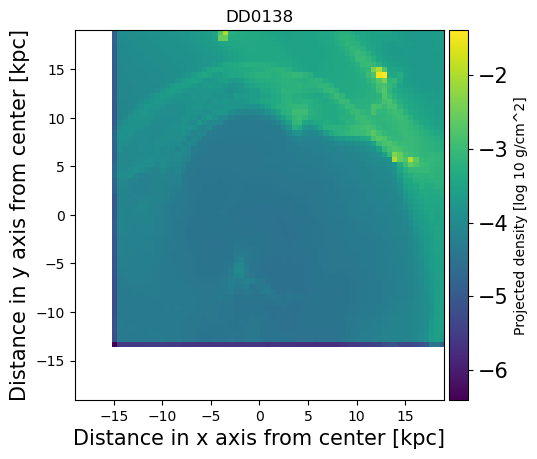

yt : [INFO     ] 2023-07-27 10:45:16,164 Parameters: current_time              = 92.566527818285
yt : [INFO     ] 2023-07-27 10:45:16,165 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:45:16,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:45:16,167 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:45:16,169 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:45:16,170 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-07-27 10:45:16,171 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:45:16,172 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:45:16,173 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:45:16,174 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|███████████████| 11675/11675 [00:01<00:00, 8103.54it/s]
yt : [INFO     ] 2023-07-27 10:45:18,046 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:45:31,274 Projection completed
yt : [INFO     ] 2023-07-27 10:45:31,276 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


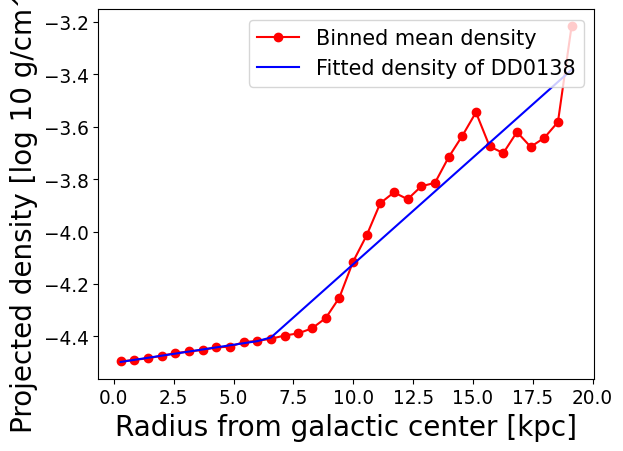

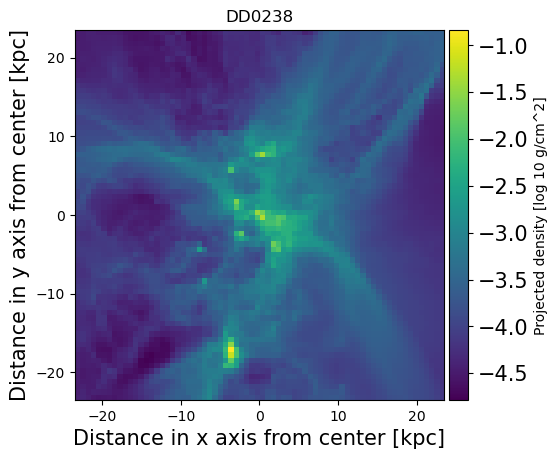

yt : [INFO     ] 2023-07-27 10:45:31,905 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2023-07-27 10:45:31,906 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:45:31,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:45:31,907 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:45:31,908 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:45:31,908 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2023-07-27 10:45:31,909 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:45:31,909 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:45:31,910 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:45:31,910 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0287/DD0287
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
2.9116806076 0.493954 0.490721 0.500203 0.495954 0.492721 0.502203    9


Parsing Hierarchy : 100%|████████████████| 7384/7384 [00:00<00:00, 11048.18it/s]
yt : [INFO     ] 2023-07-27 10:45:32,847 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:45:40,872 Projection completed
yt : [INFO     ] 2023-07-27 10:45:40,874 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


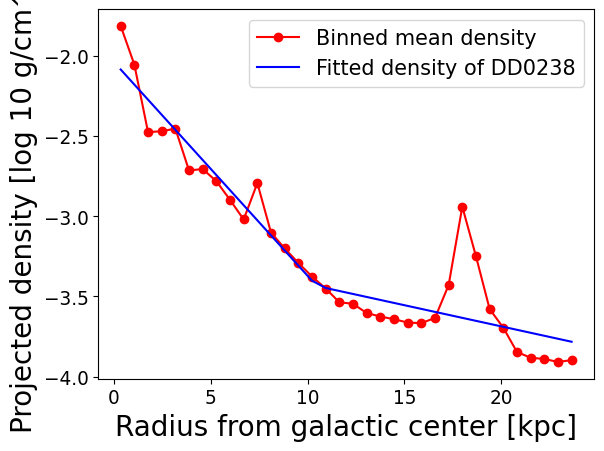

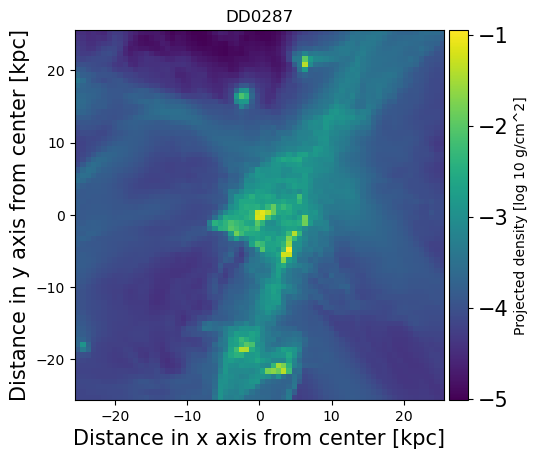

yt : [INFO     ] 2023-07-27 10:45:41,439 Parameters: current_time              = 106.31652781829
yt : [INFO     ] 2023-07-27 10:45:41,440 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:45:41,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:45:41,441 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:45:41,442 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:45:41,443 Parameters: current_redshift          = 2.8742891413864
yt : [INFO     ] 2023-07-27 10:45:41,443 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:45:41,444 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:45:41,445 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:45:41,446 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0293/DD0293
get_refine_box: using this location:      col1       col2     col3     col4    col5     col6     col7  col8
------------- -------- -------- ------- -------- -------- ------- ----
2.87428914139 0.493962 0.490687 0.50017 0.495962 0.492687 0.50217    9


Parsing Hierarchy : 100%|█████████████████| 7297/7297 [00:00<00:00, 9479.31it/s]
yt : [INFO     ] 2023-07-27 10:45:42,465 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:45:49,749 Projection completed
yt : [INFO     ] 2023-07-27 10:45:49,750 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


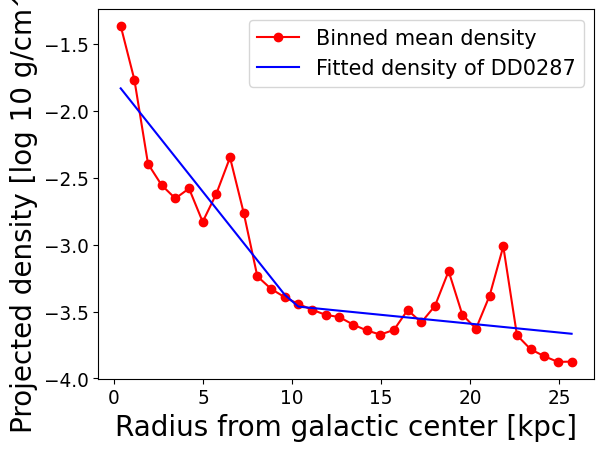

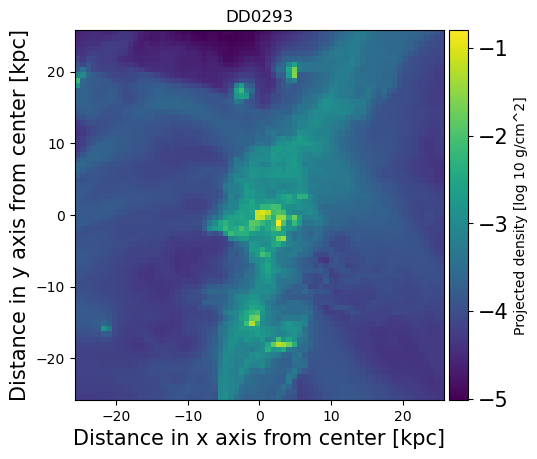

yt : [INFO     ] 2023-07-27 10:45:50,320 Parameters: current_time              = 117.56652781829
yt : [INFO     ] 2023-07-27 10:45:50,320 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:45:50,321 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:45:50,321 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:45:50,323 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:45:50,323 Parameters: current_redshift          = 2.6192132579666
yt : [INFO     ] 2023-07-27 10:45:50,324 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:45:50,325 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:45:50,326 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:45:50,326 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0338/DD0338
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.61921325797 0.493773 0.490067 0.500353 0.495773 0.492067 0.502353    9


Parsing Hierarchy : 100%|█████████████████| 8624/8624 [00:01<00:00, 8610.47it/s]
yt : [INFO     ] 2023-07-27 10:45:51,618 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:46:01,017 Projection completed
yt : [INFO     ] 2023-07-27 10:46:01,018 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


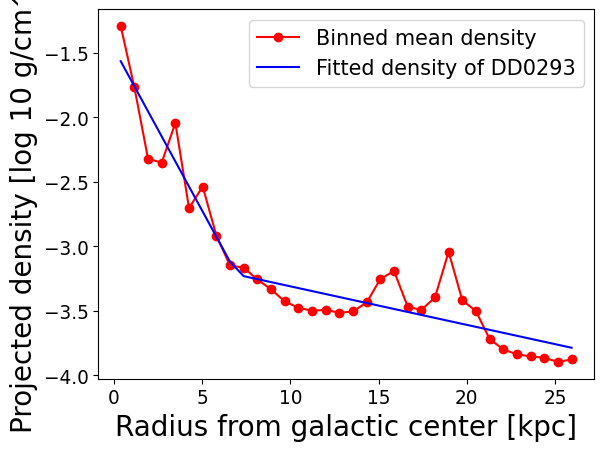

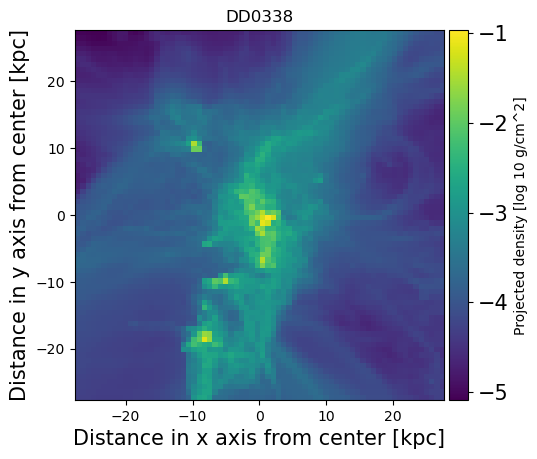

yt : [INFO     ] 2023-07-27 10:46:01,535 Parameters: current_time              = 142.56652781829
yt : [INFO     ] 2023-07-27 10:46:01,536 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:46:01,536 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:46:01,537 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:46:01,538 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:46:01,539 Parameters: current_redshift          = 2.174064272558
yt : [INFO     ] 2023-07-27 10:46:01,539 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:46:01,540 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:46:01,541 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:46:01,542 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0438/DD0438
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.17406427256 0.493252 0.488579 0.500941 0.495252 0.490579 0.502941    9


Parsing Hierarchy : 100%|█████████████████| 9619/9619 [00:01<00:00, 6782.87it/s]
yt : [INFO     ] 2023-07-27 10:46:03,295 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:47:52,889 Projection completed
yt : [INFO     ] 2023-07-27 10:47:52,890 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


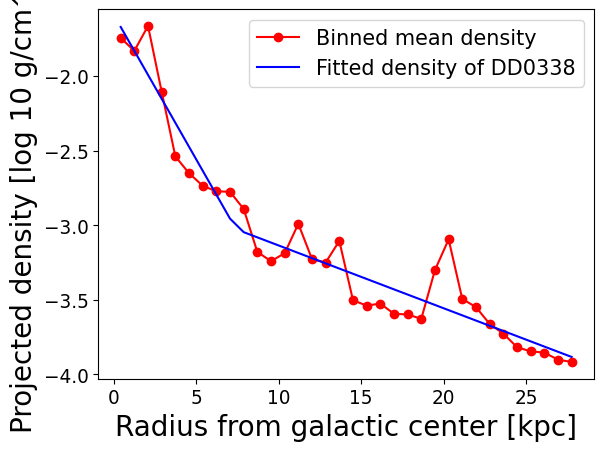

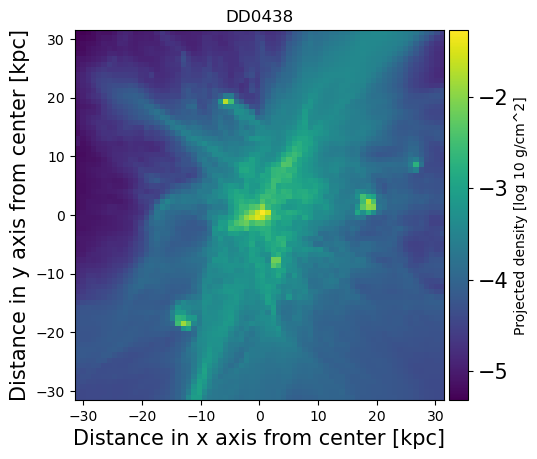

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0538/DD0538


yt : [INFO     ] 2023-07-27 10:47:53,680 Parameters: current_time              = 167.56652781829
yt : [INFO     ] 2023-07-27 10:47:53,680 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:47:53,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:47:53,682 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:47:53,683 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:47:53,684 Parameters: current_redshift          = 1.8407728906142
yt : [INFO     ] 2023-07-27 10:47:53,685 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:47:53,686 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:47:53,686 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:47:53,687 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.84077289061 0.492796 0.487204 0.501442 0.494796 0.489204 0.503442    9


Parsing Hierarchy : 100%|█████████████████| 6003/6003 [00:00<00:00, 6320.96it/s]
yt : [INFO     ] 2023-07-27 10:47:54,930 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:49:16,300 Projection completed
yt : [INFO     ] 2023-07-27 10:49:16,301 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


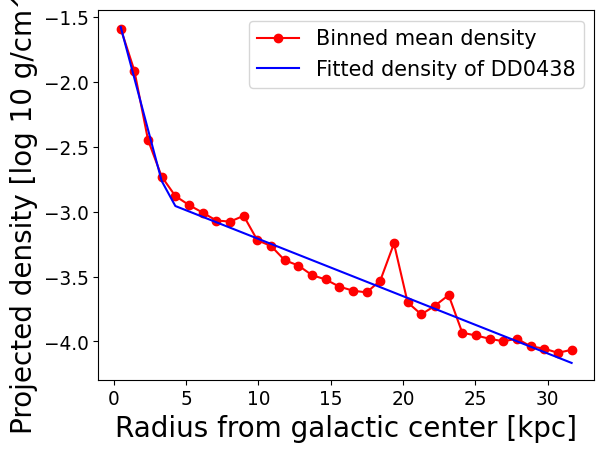

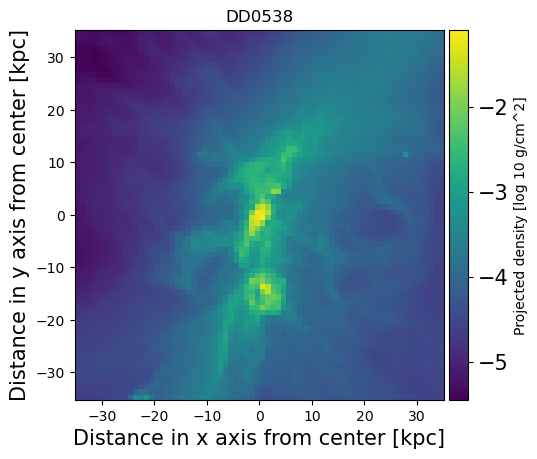

yt : [INFO     ] 2023-07-27 10:49:16,918 Parameters: current_time              = 192.56652781829
yt : [INFO     ] 2023-07-27 10:49:16,919 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:49:16,920 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:49:16,921 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:49:16,922 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:49:16,923 Parameters: current_redshift          = 1.5796008591072
yt : [INFO     ] 2023-07-27 10:49:16,923 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:49:16,924 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:49:16,925 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:49:16,925 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0638/DD0638
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.57960085911 0.49248 0.485831 0.501973 0.49448 0.487831 0.503973    9


Parsing Hierarchy : 100%|█████████████████| 7363/7363 [00:01<00:00, 6567.42it/s]
yt : [INFO     ] 2023-07-27 10:49:18,433 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:50:52,116 Projection completed
yt : [INFO     ] 2023-07-27 10:50:52,117 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


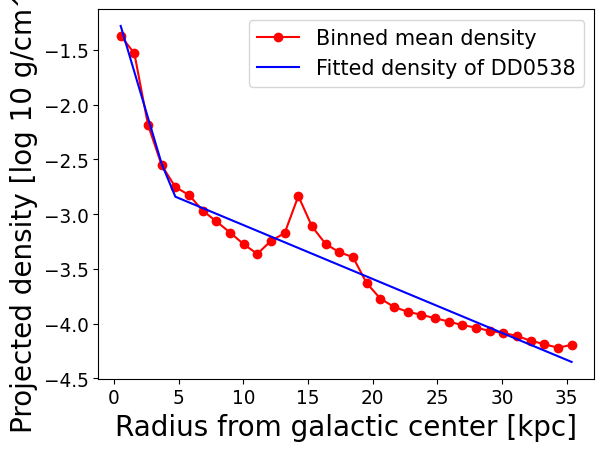

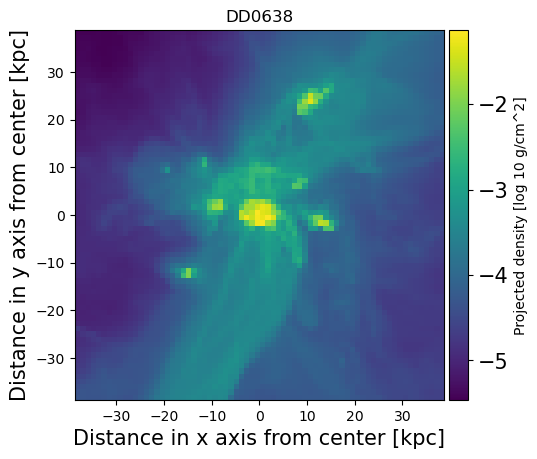

yt : [INFO     ] 2023-07-27 10:50:52,893 Parameters: current_time              = 217.56652781829
yt : [INFO     ] 2023-07-27 10:50:52,894 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:50:52,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:50:52,896 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:50:52,897 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:50:52,898 Parameters: current_redshift          = 1.3679320867642
yt : [INFO     ] 2023-07-27 10:50:52,898 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:50:52,899 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:50:52,900 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:50:52,900 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0738/DD0738
get_refine_box: using this location:      col1       col2    col3     col4    col5    col6     col7  col8
------------- ------- -------- ------- ------- -------- ------- ----
1.36793208676 0.49219 0.484532 0.50256 0.49419 0.486532 0.50456    9


Parsing Hierarchy : 100%|█████████████████| 8207/8207 [00:01<00:00, 4816.09it/s]
yt : [INFO     ] 2023-07-27 10:50:54,950 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:53:11,724 Projection completed
yt : [INFO     ] 2023-07-27 10:53:11,726 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


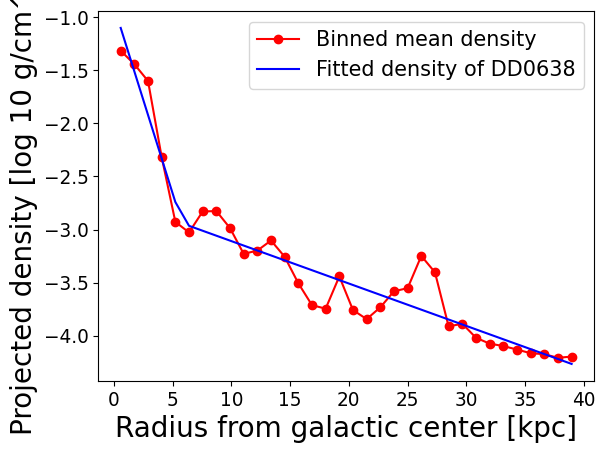

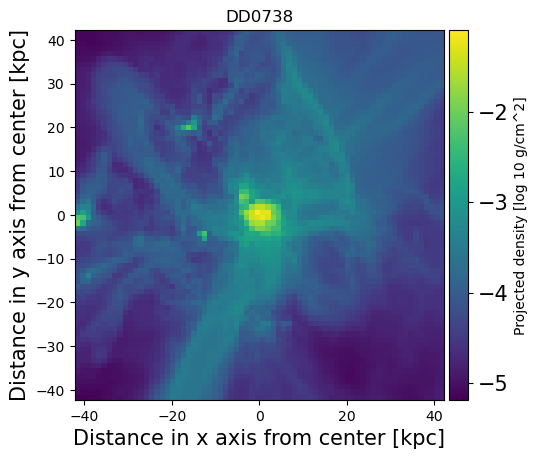

yt : [INFO     ] 2023-07-27 10:53:12,317 Parameters: current_time              = 242.56652781829
yt : [INFO     ] 2023-07-27 10:53:12,317 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:53:12,318 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:53:12,319 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:53:12,321 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:53:12,322 Parameters: current_redshift          = 1.1918720434881
yt : [INFO     ] 2023-07-27 10:53:12,322 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:53:12,323 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:53:12,323 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:53:12,324 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0838/DD0838
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.19187204349 0.49185 0.483393 0.503033 0.49385 0.485393 0.505033    9


Parsing Hierarchy : 100%|█████████████████| 6414/6414 [00:01<00:00, 5754.07it/s]
yt : [INFO     ] 2023-07-27 10:53:14,144 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:55:53,564 Projection completed
yt : [INFO     ] 2023-07-27 10:55:53,566 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


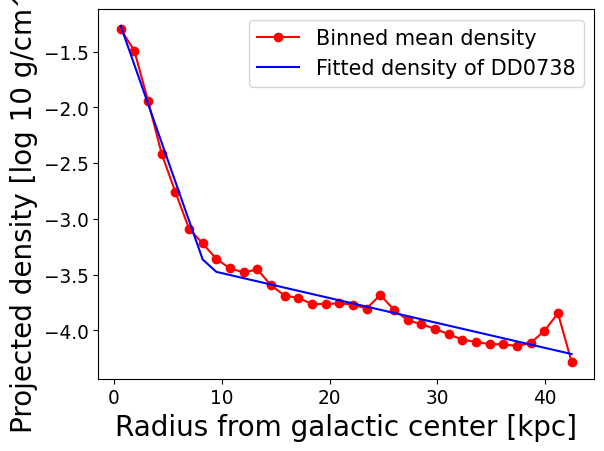

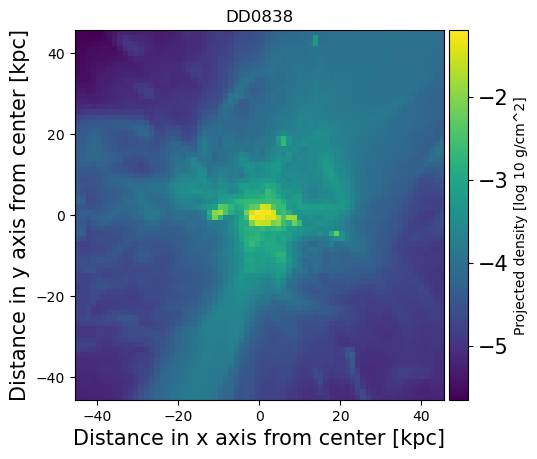

yt : [INFO     ] 2023-07-27 10:55:54,120 Parameters: current_time              = 267.56652781829
yt : [INFO     ] 2023-07-27 10:55:54,120 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:55:54,121 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:55:54,122 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:55:54,123 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:55:54,123 Parameters: current_redshift          = 1.0423765498971
yt : [INFO     ] 2023-07-27 10:55:54,124 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:55:54,125 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:55:54,125 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:55:54,126 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0938/DD0938
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
1.0423765499 0.491558 0.482256 0.503483 0.493558 0.484256 0.505483    9


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:01<00:00, 4584.40it/s]
yt : [INFO     ] 2023-07-27 10:55:55,849 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:57:27,340 Projection completed
yt : [INFO     ] 2023-07-27 10:57:27,341 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


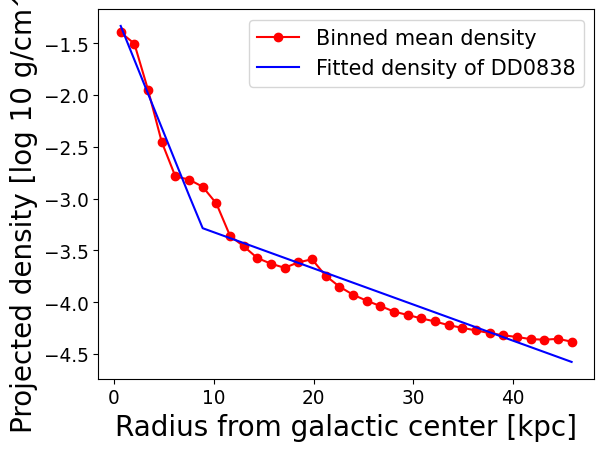

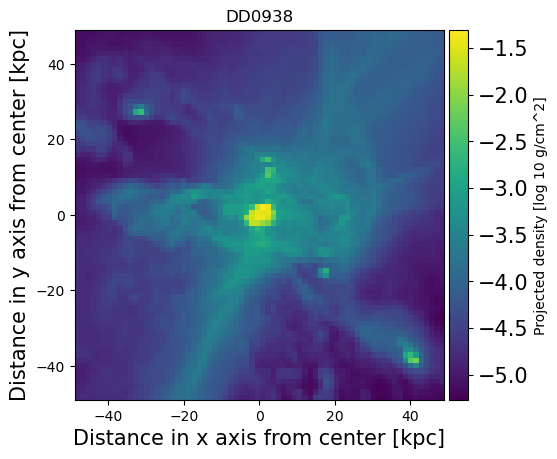

yt : [INFO     ] 2023-07-27 10:57:28,169 Parameters: current_time              = 292.31652781829
yt : [INFO     ] 2023-07-27 10:57:28,170 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:57:28,171 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:57:28,171 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:57:28,172 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:57:28,173 Parameters: current_redshift          = 0.91449134314195
yt : [INFO     ] 2023-07-27 10:57:28,173 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:57:28,174 Parameters: omega_matter              = 0.285


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1038/DD1038


yt : [INFO     ] 2023-07-27 10:57:28,175 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:57:28,176 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1        col2     col3     col4     col5     col6     col7   col8
-------------- -------- -------- -------- -------- -------- -------- ----
0.914491343142 0.491324 0.481173 0.503918 0.493324 0.483173 0.505918    9


Parsing Hierarchy : 100%|█████████████████| 5369/5369 [00:00<00:00, 5598.43it/s]
yt : [INFO     ] 2023-07-27 10:57:29,443 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:58:41,457 Projection completed
yt : [INFO     ] 2023-07-27 10:58:41,459 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


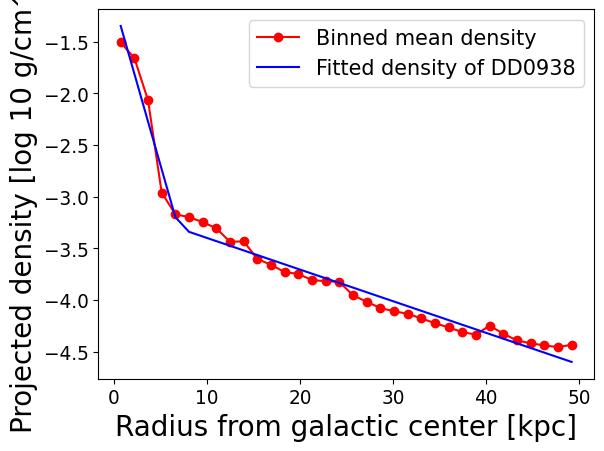

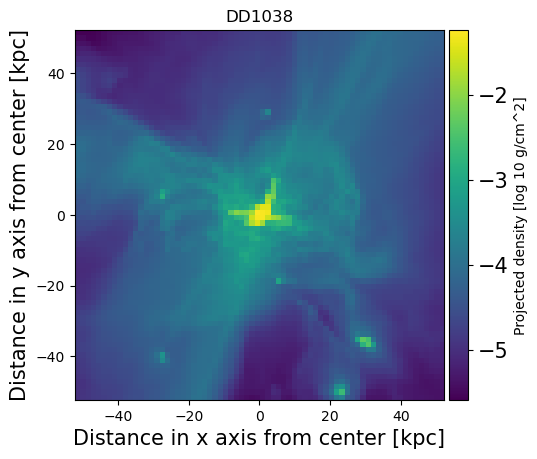

yt : [INFO     ] 2023-07-27 10:58:42,036 Parameters: current_time              = 317.31652781829
yt : [INFO     ] 2023-07-27 10:58:42,037 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:58:42,037 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:58:42,039 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:58:42,040 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:58:42,040 Parameters: current_redshift          = 0.80131183964773
yt : [INFO     ] 2023-07-27 10:58:42,041 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:58:42,041 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:58:42,042 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:58:42,043 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1138/DD1138
get_refine_box: using this location:       col1         col2    col3    col4     col5    col6    col7   col8
---------------- ------- ------- -------- ------- ------- -------- ----
0.80131183964773 0.49111 0.48016 0.504261 0.49311 0.48216 0.506261    9


Parsing Hierarchy : 100%|█████████████████| 5629/5629 [00:00<00:00, 6557.73it/s]
yt : [INFO     ] 2023-07-27 10:58:43,160 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:59:54,915 Projection completed
yt : [INFO     ] 2023-07-27 10:59:54,916 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


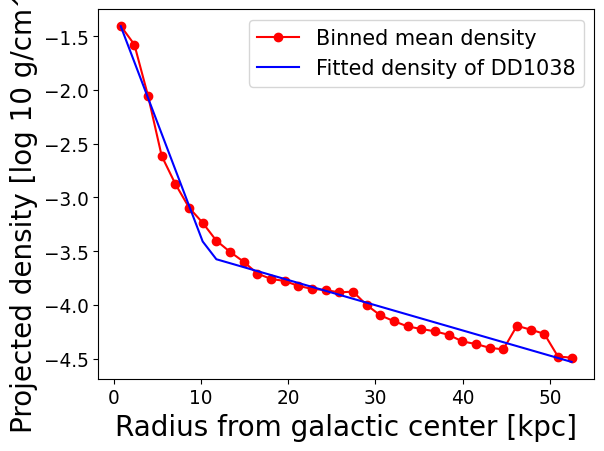

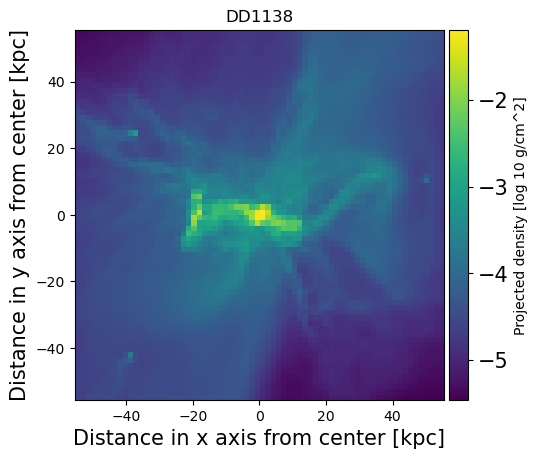

yt : [INFO     ] 2023-07-27 10:59:55,489 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-07-27 10:59:55,490 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:59:55,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:59:55,492 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:59:55,493 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:59:55,493 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-07-27 10:59:55,494 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:59:55,495 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:59:55,495 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:59:55,496 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238
get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:01<00:00, 4827.83it/s]
yt : [INFO     ] 2023-07-27 10:59:57,021 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:00:02,990 Projection completed
yt : [INFO     ] 2023-07-27 11:00:02,992 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


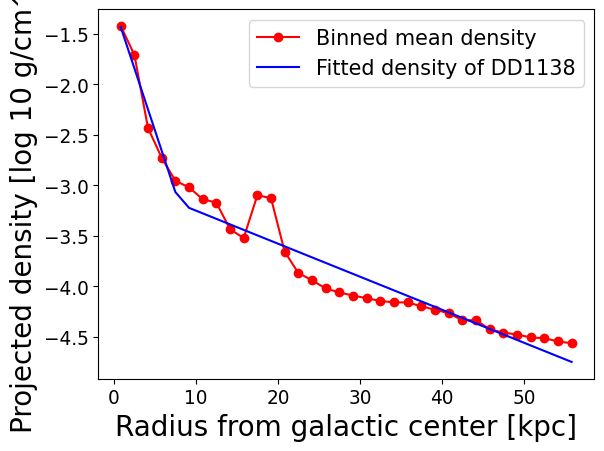

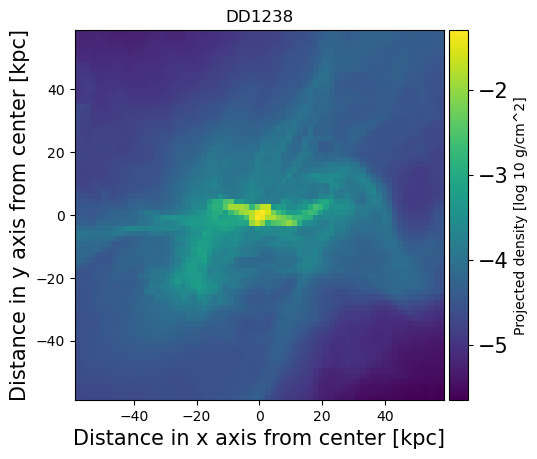

yt : [INFO     ] 2023-07-27 11:00:03,648 Parameters: current_time              = 367.31652781829
yt : [INFO     ] 2023-07-27 11:00:03,649 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:00:03,649 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:00:03,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:00:03,651 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:00:03,652 Parameters: current_redshift          = 0.61132831909135
yt : [INFO     ] 2023-07-27 11:00:03,652 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:00:03,653 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:00:03,653 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:00:03,654 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1338/DD1338
get_refine_box: using this location:       col1         col2     col3    col4     col5     col6    col7   col8
---------------- -------- ------- -------- -------- ------- -------- ----
0.61132831909135 0.490681 0.47823 0.505093 0.492681 0.48023 0.507093    9


Parsing Hierarchy : 100%|█████████████████| 6366/6366 [00:00<00:00, 8779.29it/s]
yt : [INFO     ] 2023-07-27 11:00:04,651 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:01:22,563 Projection completed
yt : [INFO     ] 2023-07-27 11:01:22,565 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


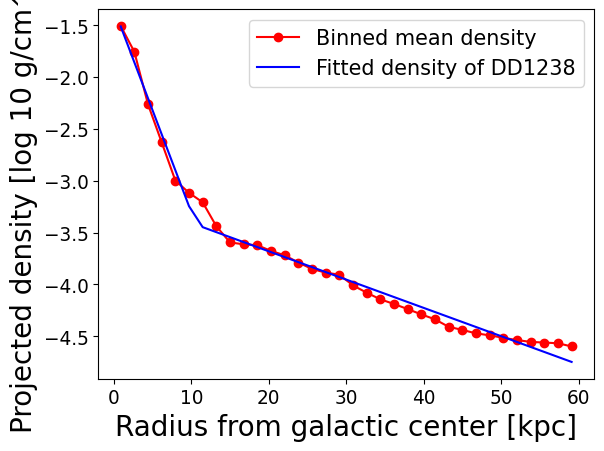

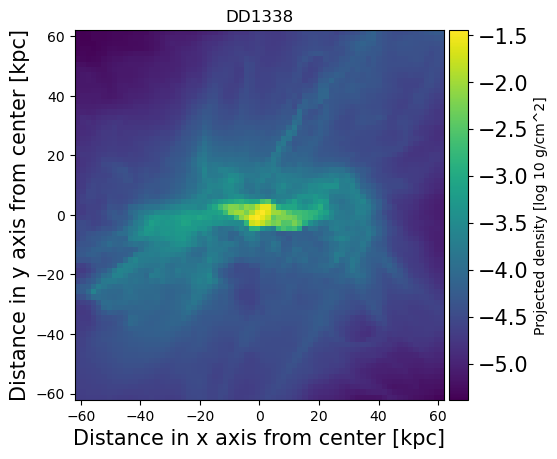

yt : [INFO     ] 2023-07-27 11:01:23,244 Parameters: current_time              = 392.31652781829
yt : [INFO     ] 2023-07-27 11:01:23,244 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:01:23,245 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:01:23,246 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:01:23,247 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:01:23,248 Parameters: current_redshift          = 0.53034842583426
yt : [INFO     ] 2023-07-27 11:01:23,248 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:01:23,249 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:01:23,250 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:01:23,251 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1438/DD1438
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.53034842583426 0.490464 0.477354 0.505497 0.492464 0.479354 0.507497    9


Parsing Hierarchy : 100%|█████████████████| 6029/6029 [00:00<00:00, 8449.20it/s]
yt : [INFO     ] 2023-07-27 11:01:24,324 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:02:41,404 Projection completed
yt : [INFO     ] 2023-07-27 11:02:41,405 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


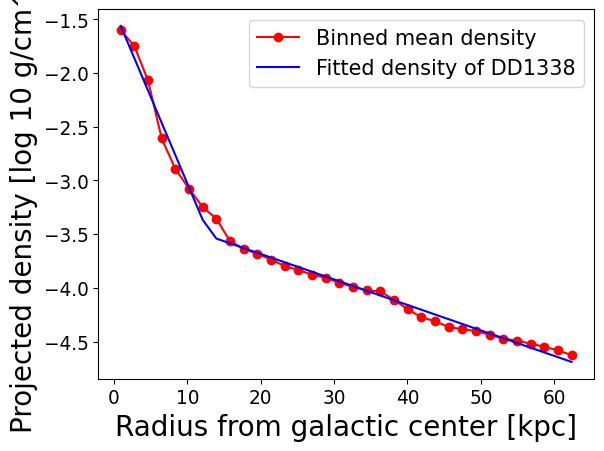

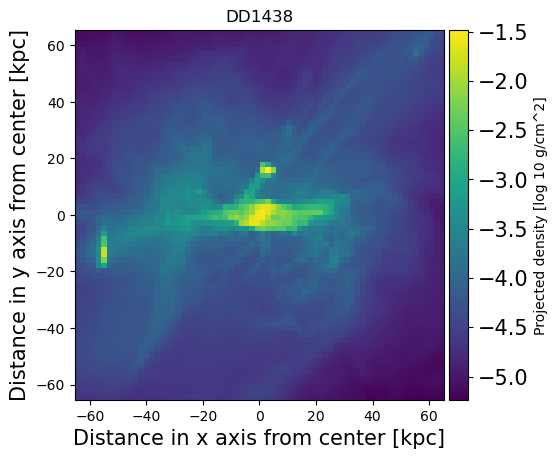

yt : [INFO     ] 2023-07-27 11:02:42,132 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-07-27 11:02:42,132 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:02:42,133 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:02:42,134 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:02:42,135 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:02:42,136 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-07-27 11:02:42,136 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:02:42,137 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:02:42,137 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:02:42,138 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:00<00:00, 6941.43it/s]
yt : [INFO     ] 2023-07-27 11:02:43,325 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:04:05,644 Projection completed
yt : [INFO     ] 2023-07-27 11:04:05,646 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


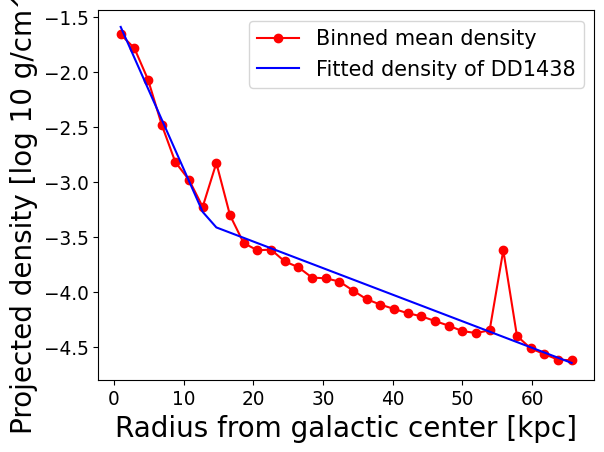

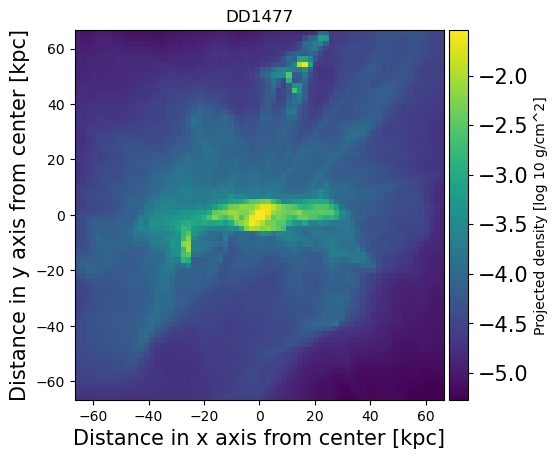

yt : [INFO     ] 2023-07-27 11:04:06,325 Parameters: current_time              = 402.31652781829
yt : [INFO     ] 2023-07-27 11:04:06,326 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:04:06,327 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:04:06,328 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:04:06,329 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:04:06,329 Parameters: current_redshift          = 0.50007848881181
yt : [INFO     ] 2023-07-27 11:04:06,330 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:04:06,331 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:04:06,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:04:06,333 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1478/DD1478
get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.50007848881181 0.49038 0.477011 0.505667 0.49238 0.479011 0.507667    9


Parsing Hierarchy : 100%|█████████████████| 5947/5947 [00:01<00:00, 5853.23it/s]
yt : [INFO     ] 2023-07-27 11:04:07,992 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:05:27,767 Projection completed
yt : [INFO     ] 2023-07-27 11:05:27,769 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


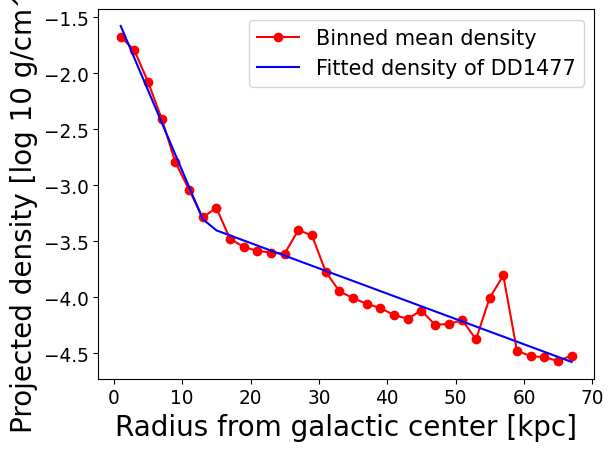

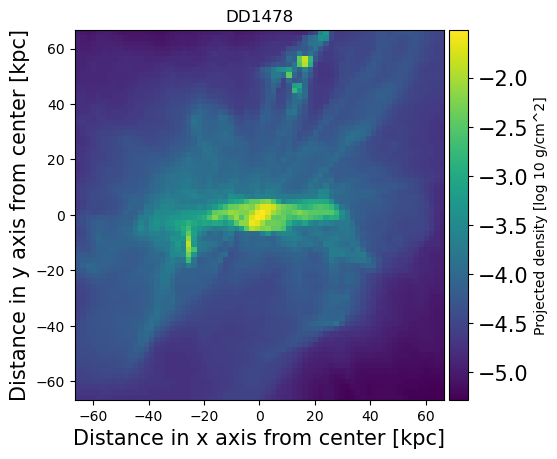

yt : [INFO     ] 2023-07-27 11:05:28,701 Parameters: current_time              = 402.56652517609
yt : [INFO     ] 2023-07-27 11:05:28,701 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:05:28,702 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:05:28,703 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:05:28,703 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:05:28,704 Parameters: current_redshift          = 0.49933608114367
yt : [INFO     ] 2023-07-27 11:05:28,705 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:05:28,705 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:05:28,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:05:28,707 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1479/DD1479
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.49933608114367 0.490378 0.477002 0.505671 0.492378 0.479002 0.507671    9


Parsing Hierarchy : 100%|█████████████████| 5985/5985 [00:00<00:00, 8678.53it/s]
yt : [INFO     ] 2023-07-27 11:05:29,741 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:06:47,298 Projection completed
yt : [INFO     ] 2023-07-27 11:06:47,299 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


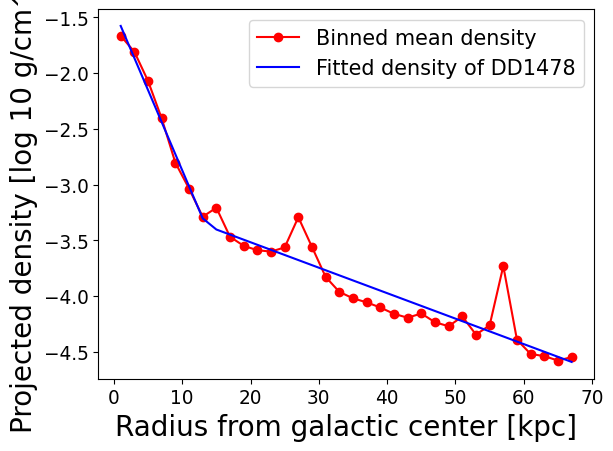

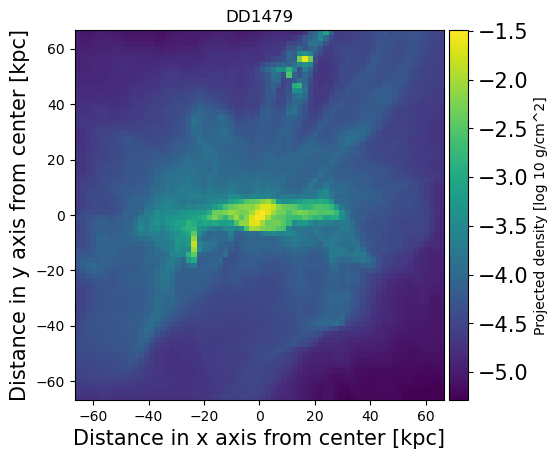

yt : [INFO     ] 2023-07-27 11:06:48,018 Parameters: current_time              = 417.31652781829
yt : [INFO     ] 2023-07-27 11:06:48,019 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:06:48,020 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:06:48,021 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:06:48,023 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:06:48,023 Parameters: current_redshift          = 0.45670560906839
yt : [INFO     ] 2023-07-27 11:06:48,024 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:06:48,025 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:06:48,025 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:06:48,026 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1538/DD1538
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.45670560906839 0.490252 0.476517 0.505875 0.492252 0.478517 0.507875    9


Parsing Hierarchy : 100%|█████████████████| 6119/6119 [00:00<00:00, 6150.18it/s]
yt : [INFO     ] 2023-07-27 11:06:49,699 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:08:08,666 Projection completed
yt : [INFO     ] 2023-07-27 11:08:08,668 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


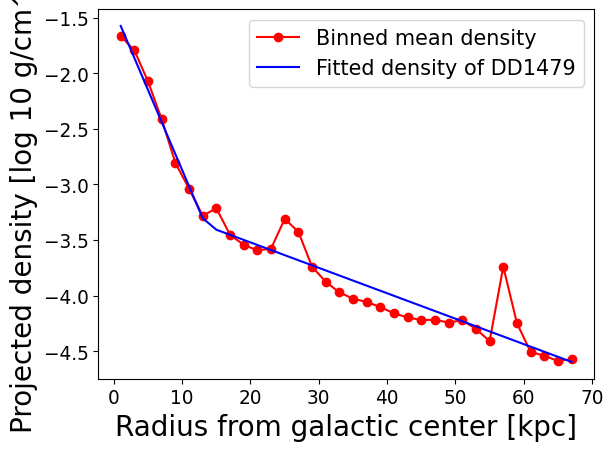

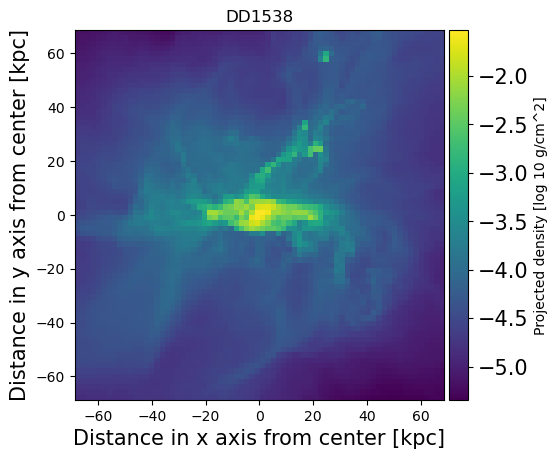

yt : [INFO     ] 2023-07-27 11:08:09,283 Parameters: current_time              = 442.31652781829
yt : [INFO     ] 2023-07-27 11:08:09,283 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:08:09,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:08:09,285 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:08:09,286 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:08:09,287 Parameters: current_redshift          = 0.3892837031507
yt : [INFO     ] 2023-07-27 11:08:09,288 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:08:09,288 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:08:09,289 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:08:09,289 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1638/DD1638
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.38929394169243 0.490071 0.475697 0.506226 0.492071 0.477697 0.508226    9


Parsing Hierarchy : 100%|█████████████████| 5613/5613 [00:00<00:00, 7135.12it/s]
yt : [INFO     ] 2023-07-27 11:08:10,317 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:09:23,153 Projection completed
yt : [INFO     ] 2023-07-27 11:09:23,154 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


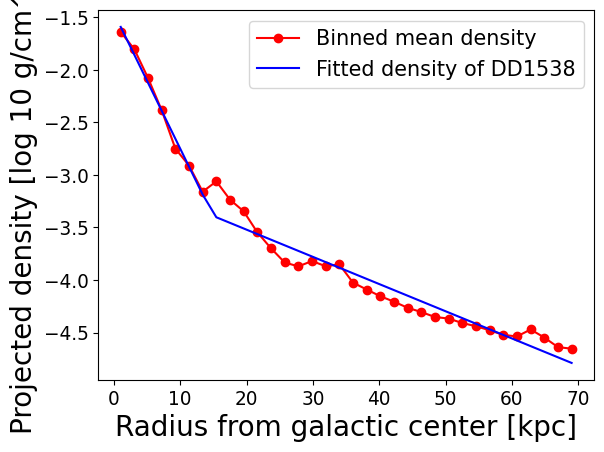

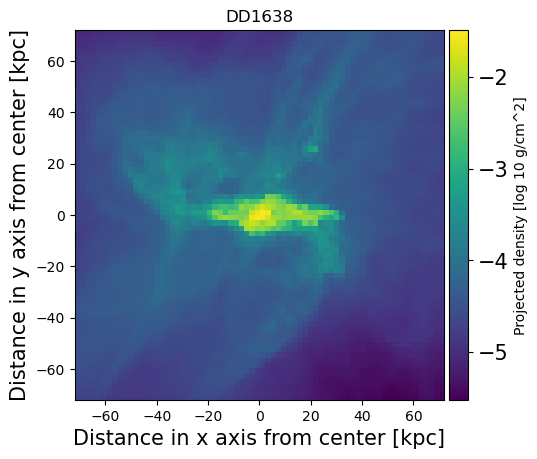

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1738/DD1738


yt : [INFO     ] 2023-07-27 11:09:23,870 Parameters: current_time              = 467.31652781829
yt : [INFO     ] 2023-07-27 11:09:23,871 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:09:23,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:09:23,873 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:09:23,874 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:09:23,874 Parameters: current_redshift          = 0.32721407621449
yt : [INFO     ] 2023-07-27 11:09:23,875 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:09:23,876 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:09:23,876 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:09:23,877 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.32722883488872 0.489878 0.474896 0.506564 0.491878 0.476896 0.508564    9


Parsing Hierarchy : 100%|█████████████████| 5309/5309 [00:00<00:00, 5377.45it/s]
yt : [INFO     ] 2023-07-27 11:09:25,103 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:10:32,928 Projection completed
yt : [INFO     ] 2023-07-27 11:10:32,929 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


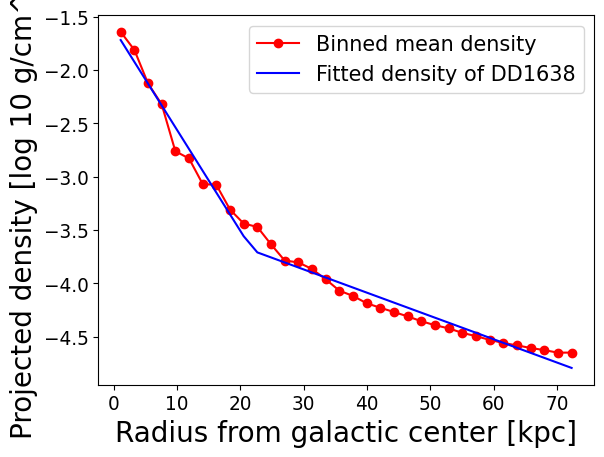

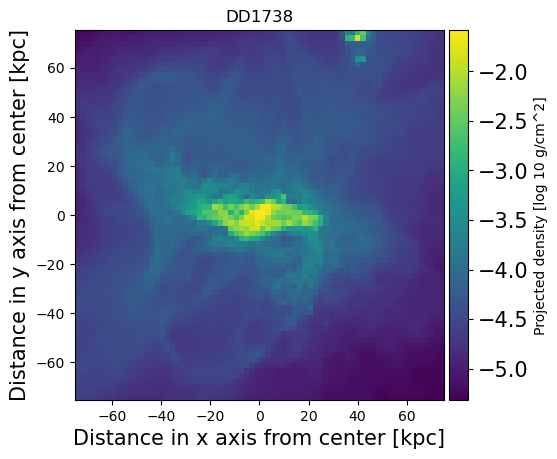

yt : [INFO     ] 2023-07-27 11:10:33,546 Parameters: current_time              = 492.31652781829
yt : [INFO     ] 2023-07-27 11:10:33,547 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:10:33,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:10:33,548 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:10:33,550 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:10:33,550 Parameters: current_redshift          = 0.26978215732692
yt : [INFO     ] 2023-07-27 11:10:33,551 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:10:33,552 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:10:33,553 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:10:33,553 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1838/DD1838
get_refine_box: using this location:       col1        col2     col3     col4     col5     col6     col7   col8
--------------- -------- -------- -------- -------- -------- -------- ----
0.2697939304999 0.489703 0.474121 0.506863 0.491703 0.476121 0.508863    9


Parsing Hierarchy : 100%|█████████████████| 5365/5365 [00:00<00:00, 5553.03it/s]
yt : [INFO     ] 2023-07-27 11:10:34,757 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:11:45,065 Projection completed
yt : [INFO     ] 2023-07-27 11:11:45,067 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


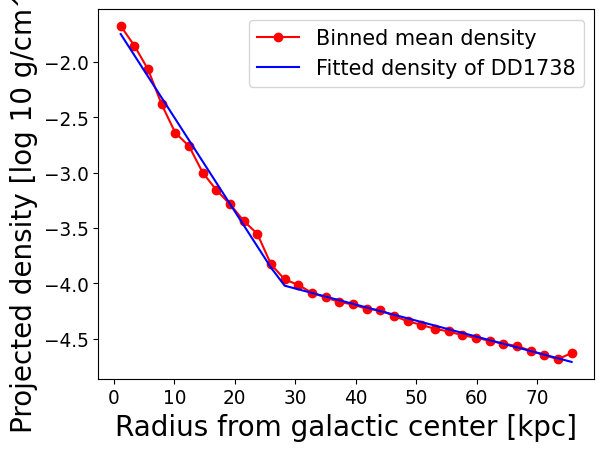

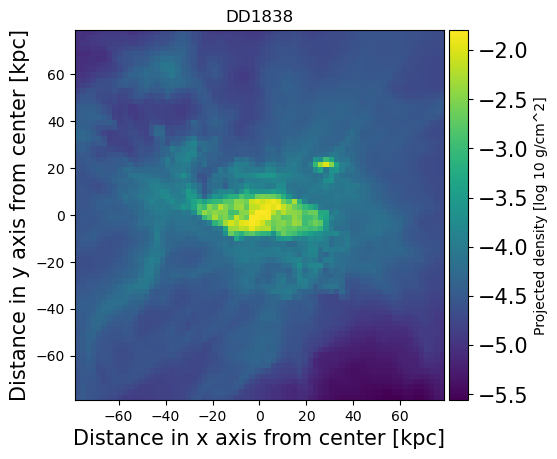

yt : [INFO     ] 2023-07-27 11:11:45,729 Parameters: current_time              = 517.31652781829
yt : [INFO     ] 2023-07-27 11:11:45,730 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:11:45,731 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:11:45,732 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:11:45,733 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:11:45,734 Parameters: current_redshift          = 0.21639444449422
yt : [INFO     ] 2023-07-27 11:11:45,735 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:11:45,736 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:11:45,736 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:11:45,737 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1938/DD1938
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.21640266677445 0.489548 0.473393 0.507161 0.491548 0.475393 0.509161    9


Parsing Hierarchy : 100%|█████████████████| 4944/4944 [00:00<00:00, 6597.70it/s]
yt : [INFO     ] 2023-07-27 11:11:46,782 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:12:51,335 Projection completed
yt : [INFO     ] 2023-07-27 11:12:51,336 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


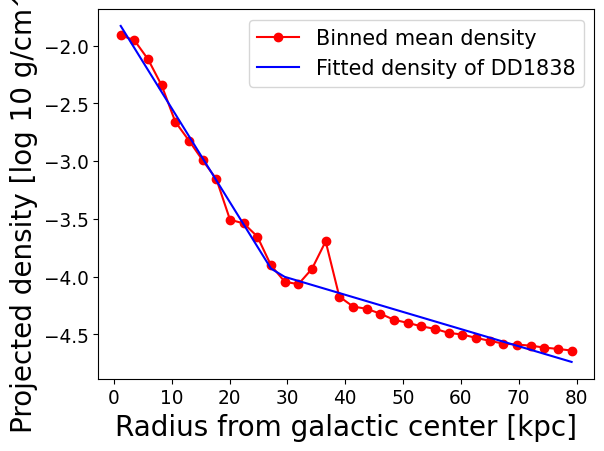

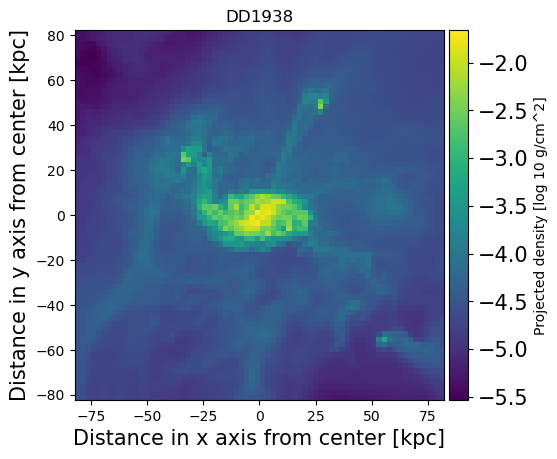

yt : [INFO     ] 2023-07-27 11:12:52,146 Parameters: current_time              = 542.31652781829
yt : [INFO     ] 2023-07-27 11:12:52,146 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:12:52,147 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:12:52,148 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:12:52,149 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:12:52,150 Parameters: current_redshift          = 0.1665627895111
yt : [INFO     ] 2023-07-27 11:12:52,151 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:12:52,151 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:12:52,152 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:12:52,153 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2038/DD2038
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.16656997024797 0.489403 0.472708 0.507468 0.491403 0.474708 0.509468    9


Parsing Hierarchy : 100%|█████████████████| 5224/5224 [00:00<00:00, 6236.47it/s]
yt : [INFO     ] 2023-07-27 11:12:53,211 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:13:59,903 Projection completed
yt : [INFO     ] 2023-07-27 11:13:59,905 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


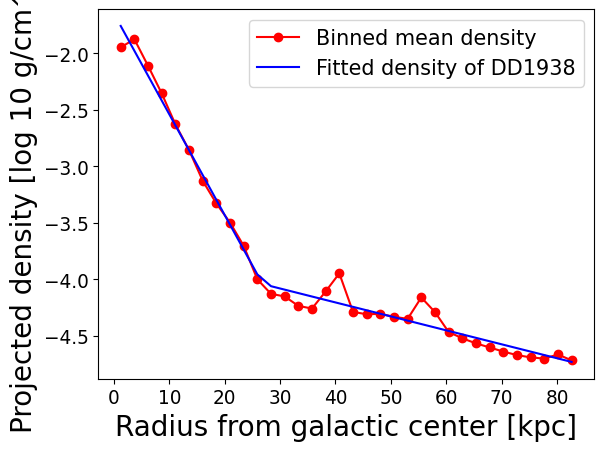

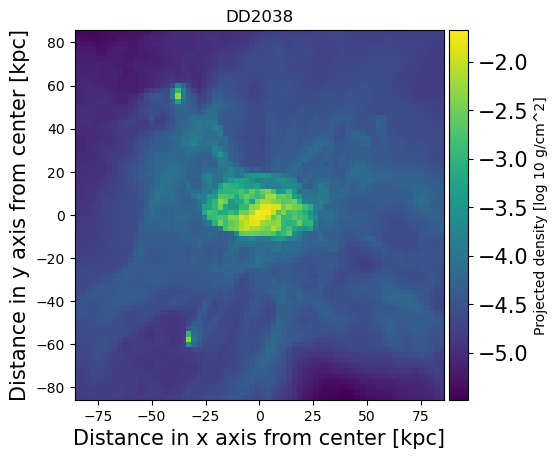

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2138/DD2138


yt : [INFO     ] 2023-07-27 11:14:00,814 Parameters: current_time              = 567.31652781829
yt : [INFO     ] 2023-07-27 11:14:00,814 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:14:00,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:14:00,816 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:14:00,818 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:14:00,818 Parameters: current_redshift          = 0.11988207020675
yt : [INFO     ] 2023-07-27 11:14:00,819 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:14:00,820 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:14:00,821 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:14:00,822 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.11989107535193 0.489254 0.472056 0.507771 0.491254 0.474056 0.509771    9


Parsing Hierarchy : 100%|█████████████████| 4682/4682 [00:00<00:00, 6346.74it/s]
yt : [INFO     ] 2023-07-27 11:14:01,768 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:15:02,742 Projection completed
yt : [INFO     ] 2023-07-27 11:15:02,744 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


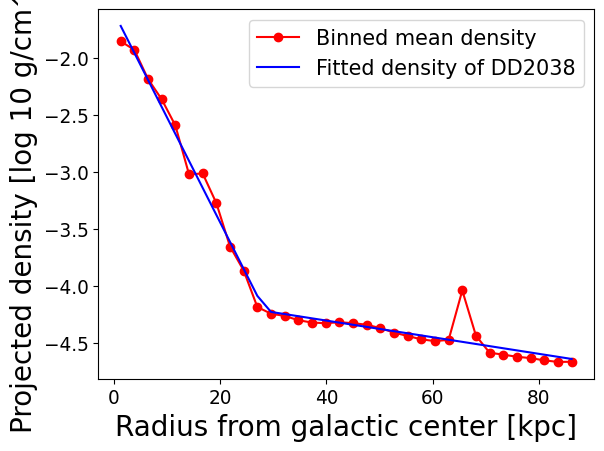

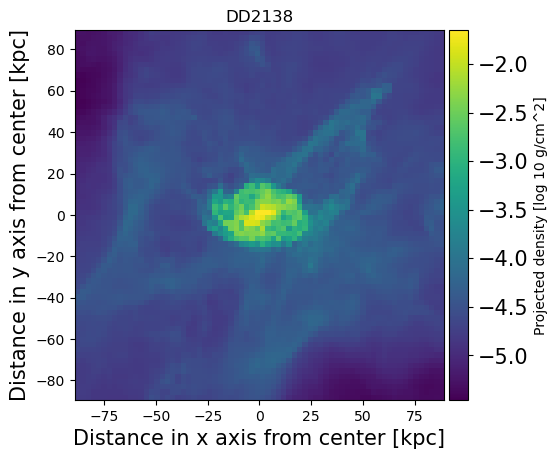

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2238/DD2238


yt : [INFO     ] 2023-07-27 11:15:03,491 Parameters: current_time              = 592.31652781829
yt : [INFO     ] 2023-07-27 11:15:03,492 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:15:03,494 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:15:03,495 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:15:03,496 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:15:03,497 Parameters: current_redshift          = 0.076013204837093
yt : [INFO     ] 2023-07-27 11:15:03,498 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:15:03,499 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:15:03,499 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:15:03,500 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.076025451160672 0.489123 0.471432 0.508053 0.491123 0.473432 0.510053    9


Parsing Hierarchy : 100%|█████████████████| 4688/4688 [00:00<00:00, 5534.16it/s]
yt : [INFO     ] 2023-07-27 11:15:04,579 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:16:05,964 Projection completed
yt : [INFO     ] 2023-07-27 11:16:05,966 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


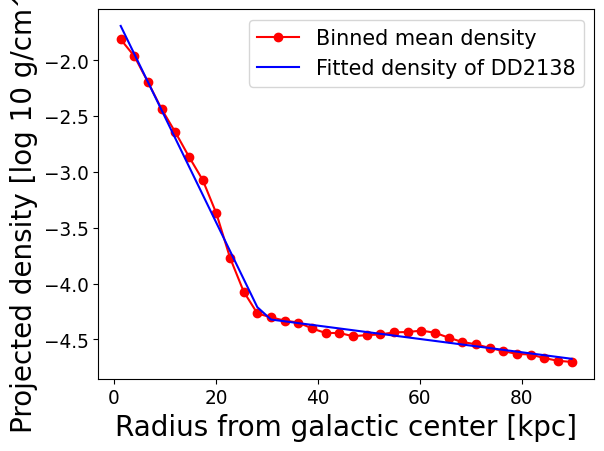

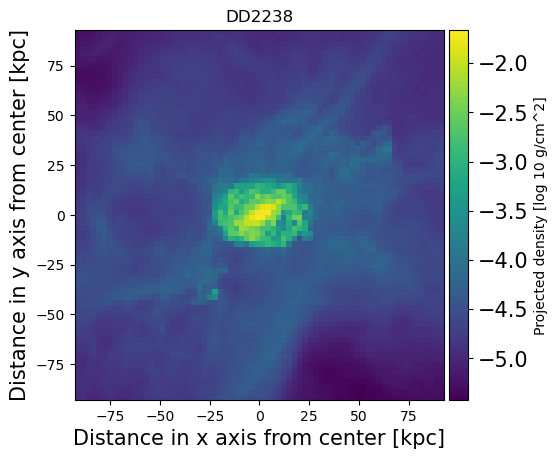

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2288/DD2288


yt : [INFO     ] 2023-07-27 11:16:06,866 Parameters: current_time              = 604.81652781829
yt : [INFO     ] 2023-07-27 11:16:06,866 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:16:06,867 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:16:06,868 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:16:06,869 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:16:06,870 Parameters: current_redshift          = 0.055049291735707
yt : [INFO     ] 2023-07-27 11:16:06,870 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:16:06,871 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:16:06,872 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:16:06,872 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.055055663741937 0.489056 0.471131 0.508189 0.491056 0.473131 0.510189    9


Parsing Hierarchy : 100%|█████████████████| 4745/4745 [00:01<00:00, 2811.71it/s]
yt : [INFO     ] 2023-07-27 11:16:08,959 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:17:14,866 Projection completed
yt : [INFO     ] 2023-07-27 11:17:14,867 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


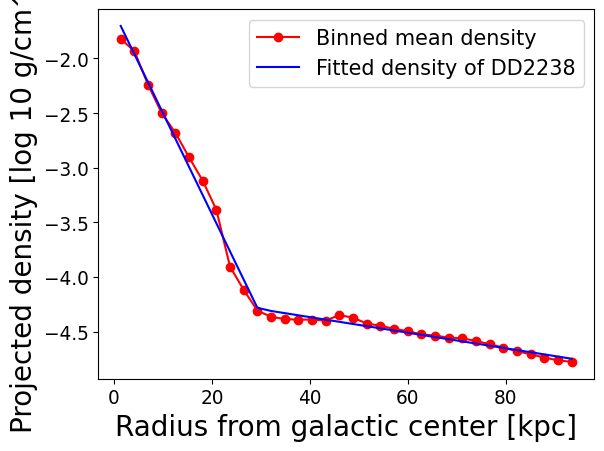

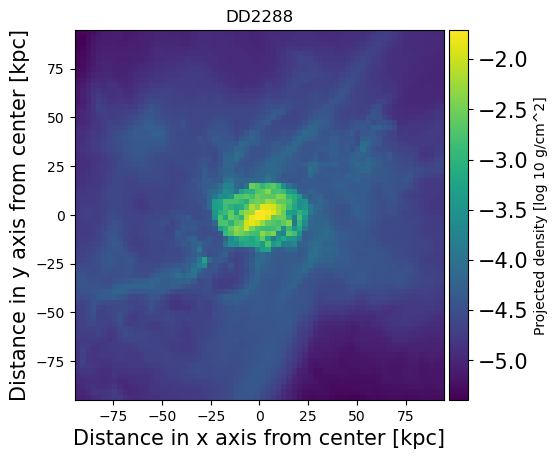

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2289/DD2289


yt : [INFO     ] 2023-07-27 11:17:15,613 Parameters: current_time              = 605.06652781829
yt : [INFO     ] 2023-07-27 11:17:15,614 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:17:15,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:17:15,616 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:17:15,617 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:17:15,618 Parameters: current_redshift          = 0.054634911934635
yt : [INFO     ] 2023-07-27 11:17:15,619 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:17:15,619 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:17:15,620 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:17:15,621 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.054642475638284 0.489054 0.471125 0.508191 0.491054 0.473125 0.510191    9


Parsing Hierarchy : 100%|█████████████████| 4798/4798 [00:00<00:00, 6695.81it/s]
yt : [INFO     ] 2023-07-27 11:17:16,579 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:18:22,806 Projection completed
yt : [INFO     ] 2023-07-27 11:18:22,807 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


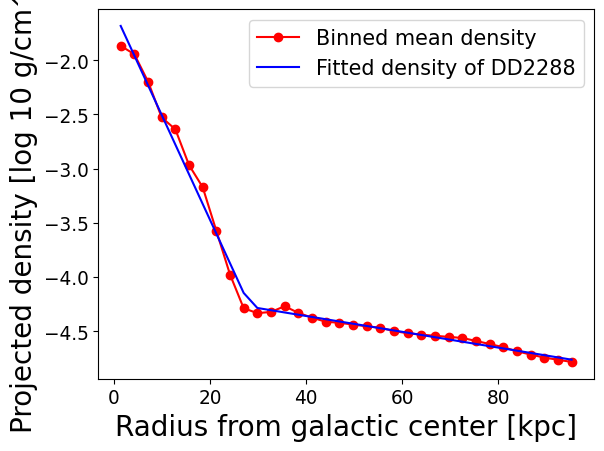

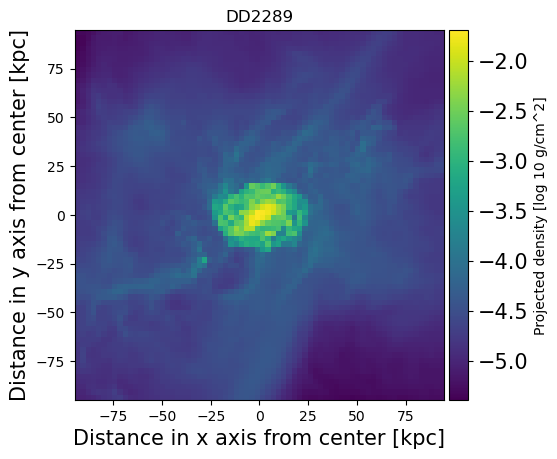

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2338/DD2338


yt : [INFO     ] 2023-07-27 11:18:23,772 Parameters: current_time              = 617.31652781829
yt : [INFO     ] 2023-07-27 11:18:23,772 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:18:23,773 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:18:23,774 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:18:23,775 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:18:23,776 Parameters: current_redshift          = 0.034670076640073
yt : [INFO     ] 2023-07-27 11:18:23,776 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:18:23,777 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:18:23,778 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:18:23,778 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4    col5     col6     col7  col8
----------------- -------- -------- ------- -------- -------- ------- ----
0.034684446722936 0.488987 0.470833 0.50832 0.490987 0.472833 0.51032    9


Parsing Hierarchy : 100%|█████████████████| 4505/4505 [00:00<00:00, 5234.44it/s]
yt : [INFO     ] 2023-07-27 11:18:24,871 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:19:25,425 Projection completed
yt : [INFO     ] 2023-07-27 11:19:25,426 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


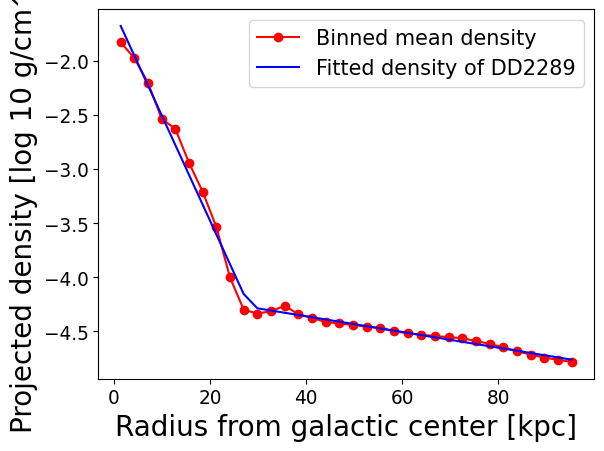

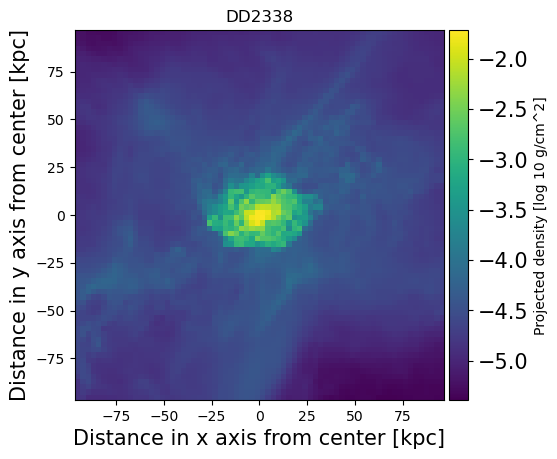

yt : [INFO     ] 2023-07-27 11:19:26,056 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-27 11:19:26,056 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:19:26,057 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:19:26,058 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:19:26,060 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:19:26,060 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-27 11:19:26,061 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:19:26,062 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:19:26,062 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:19:26,063 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2427/DD2427
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 4589.06it/s]
yt : [INFO     ] 2023-07-27 11:19:27,208 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:20:25,466 Projection completed
yt : [INFO     ] 2023-07-27 11:20:25,468 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


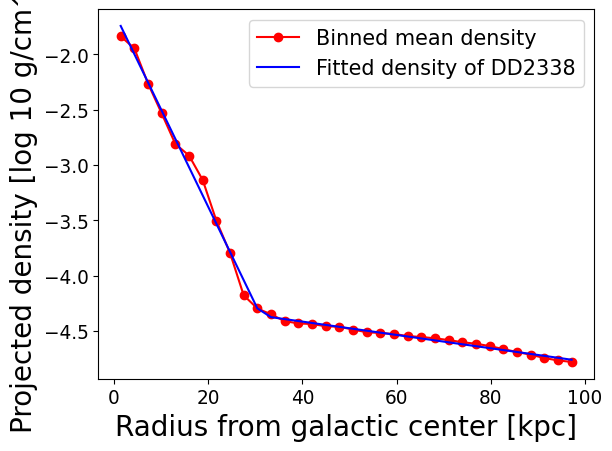

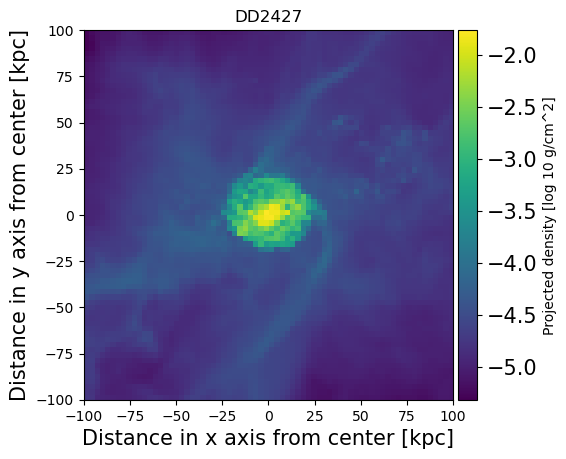

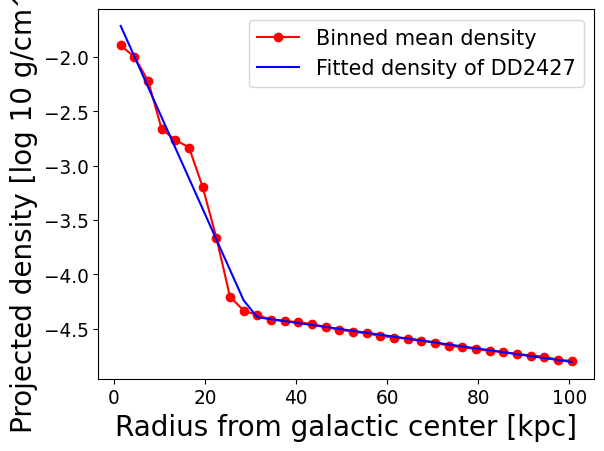

In [8]:
redshiftlist = [] #This part will be replaced with pandas later. 
cutofflist = [] #same 
timelist = [] #same 

for DD in sorted_dd_list:
    try:  
        snap = DD  # name of the snapshot output 
        plotlabel_segment = 'Fitted density of' + " " + snap
        snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives

        ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
        z = ds.get_parameter("CosmologyCurrentRedshift")
        current_time = ds.current_time.in_units('Gyr').value
        width = 200/(1+z) #[kpc]
        max_radius = width/2 #[kpc]
        binsize = 3/(z+1) #[kpc]
        
        #Density cutoff part should be here. 
    
        frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

        OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

        radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)
        
        radiuslist = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist), radiuslist))

        quantitylist  = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist), quantitylist))
        #1.77268701e+01, -3.91229778e+00, -1.21229325e-01, -6.12439042e-03 FIRST TRIAL 
        p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist),
                                   p0 = [7.5, -3.91229778e+00, -1.21229325e-01, -6.12439042e-03])
        #p : popt(optimization parameter) / e : pcov(covariance of popt)

        projection_plot = projection(frb, field, width, colorlabel, axis, snap, fontsize = 15)
        segment_plot = plotting(radiuslist, np.log10(quantitylist), piecewise_linear(radiuslist, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
 
        segment_plot.savefig(output_dir + snap + "_Density_Profile.jpg", bbox_inches = 'tight')
        projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")
    
        timepara = ds.current_time.in_units('Gyr').value + 0
        redshiftlist.append(z) #[z]
        cutofflist.append(p[0]) #[kpc]
        timelist.append(timepara) #[Gyr]
        
    except:
        print("Error with" +" "+ snap)
        pass 

In [9]:
#pandadata = {'Rdshift' : redshiftlist, 'Current time' : timelist, 'Cut-off radius' : cutofflist}
#Pd_dataframe = pd.DataFrame(data=d)
#Pd_dataframe4

In [10]:
cutofflist

[6.47276654448321,
 10.480267008373072,
 10.099881636514127,
 6.981417795303846,
 7.4142524603841595,
 3.711770158934295,
 4.408379655229585,
 5.801345208935245,
 8.562295114521671,
 8.849540920268115,
 6.951562212918919,
 10.863611275279089,
 7.974574184723168,
 10.609202880294056,
 13.050720367532717,
 13.532150378719196,
 13.458611851213336,
 13.449136641442129,
 13.484457800668835,
 14.962190866582926,
 21.953599857189047,
 27.84553552091404,
 27.71962902857445,
 26.857754171821874,
 28.44232186457805,
 29.202795479670158,
 29.38431234477205,
 28.340277515871247,
 28.26808991464318,
 31.2014702533341,
 30.065082334424975]

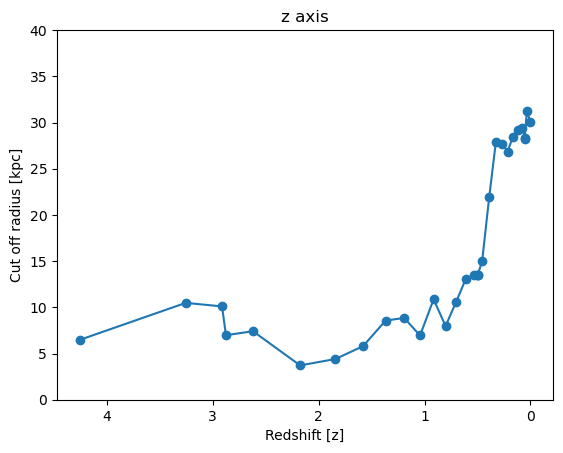

In [11]:
plt.plot(redshiftlist, cutofflist,'-o')
plt.ylabel("Cut off radius [kpc]") #actually in kpc 
plt.ylim([0,40])
plt.xlabel("Redshift [z]")
plt.title("z axis")
plt.gca().invert_xaxis()

In [12]:
cutofflist_z = cutofflist
print(cutofflist_z)

[6.47276654448321, 10.480267008373072, 10.099881636514127, 6.981417795303846, 7.4142524603841595, 3.711770158934295, 4.408379655229585, 5.801345208935245, 8.562295114521671, 8.849540920268115, 6.951562212918919, 10.863611275279089, 7.974574184723168, 10.609202880294056, 13.050720367532717, 13.532150378719196, 13.458611851213336, 13.449136641442129, 13.484457800668835, 14.962190866582926, 21.953599857189047, 27.84553552091404, 27.71962902857445, 26.857754171821874, 28.44232186457805, 29.202795479670158, 29.38431234477205, 28.340277515871247, 28.26808991464318, 31.2014702533341, 30.065082334424975]


In [13]:
timelist_z = timelist

In [14]:
redshiftlisT_z = redshiftlist

In [15]:
np.save('z_axis_timelist', timelist_z)
np.save('z_axis_redshift', redshiftlisT_z)
np.save('z_axis_cutofflist', cutofflist_z)